In [3]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
# Definition of Renyi Divergence
class RenyiDivergence(nn.Module):
    def __init__(self, alpha=0.5):
        super(RenyiDivergence, self).__init__()
        self.alpha = alpha
    def forward(self, input_logits, target_logits):
        q = torch.softmax(input_logits,dim=1)
        p = torch.softmax(target_logits,dim=1)
        
        if self.alpha == 1: # KL Divergence
            return torch.sum(p * torch.log(p/q),dim=1).mean()
        
        return 1/(self.alpha-1) * torch.log(torch.sum(torch.pow(p,self.alpha)*torch.pow(q,1-self.alpha),dim=1)).mean()

In [38]:
x = torch.tensor([[0.4,0.1,-0.3],[0.2,0.1,-0.1]],requires_grad=True)
y = torch.tensor([[1.4,0.1,-1.3],[0.2,1.8,-0.8]])
output = RenyiDivergence(alpha=0.1)(x/5,y/5)
output.backward()
x.grad

tensor([[-6.8010e-04,  3.5558e-05,  6.4454e-04],
        [ 2.4198e-04, -9.1478e-04,  6.7280e-04]])

In [4]:
# Example of divergence being infinity
#y = torch.tensor([[-0.7753, -0.7236, -0.6072, -0.8284, -0.8085, -0.8923, -0.6853, -0.8315,-0.8302, -0.7934]])
#x = torch.tensor([[-9.7151e+00, -7.6585e+00, -7.3228e+00, -7.9473e-08, -1.0569e+01,-6.7095e+00, -1.1969e+01, -7.1102e+00, -5.1660e+00, -6.2902e+00]])

In [20]:
## Preparation for plot creation
Q = torch.tensor([[1/3,2/3]])
Q = torch.log(Q)
lists = []
for alpha in [0.5,1,2,10]:
    list = []
    for p in range(501):
        P = torch.tensor([[p/500,1-p/500]])
        P = torch.log(P)
        divergence = RenyiDivergence(alpha=alpha)(Q,P)
        list.append(divergence)
    lists.append(list)
    
P = torch.tensor([[1/3,2/3]])
P = torch.log(P)
lists_2 = []
for alpha in [0.5,1,2,10]:
    list = []
    for q in range(501):
        Q = torch.tensor([[q/500,1-q/500]])
        Q = torch.log(Q)
        divergence = RenyiDivergence(alpha=alpha)(Q,P)
        list.append(divergence)
    lists_2.append(list)

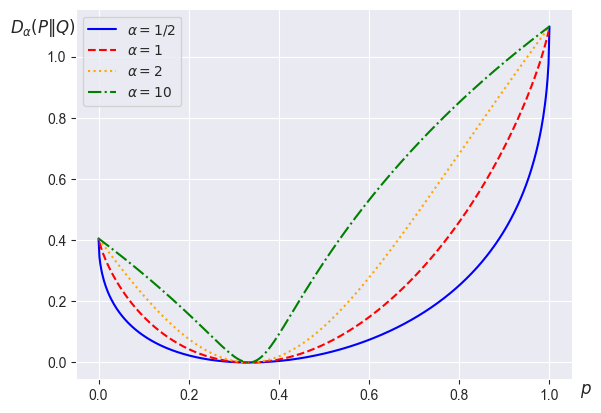

In [21]:
## Ploting
fig, ax = plt.subplots()

ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists[0])), color='blue', linestyle='-',
        label=r'$\alpha = 1/2$')
ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists[1])), color='red', linestyle='--',
        label=r'$\alpha = 1$')
ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists[2])), color='orange', linestyle=':',
        label=r'$\alpha = 2$')
ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists[3])), color='green', linestyle='-.',
        label=r'$\alpha = 10$')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.annotate(r'$p$', xy=(1.05, 0), xytext=(10, -20),
            textcoords='offset points', ha='center', va='center', fontsize=12)

ax.annotate(r'$D_\alpha(P \| Q)$', xy=(0, 1.05), xytext=(-40, 10),
            textcoords='offset points', ha='center', va='center', fontsize=12)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.legend()

fig.savefig('Renyi_Divergence.png')

plt.show()


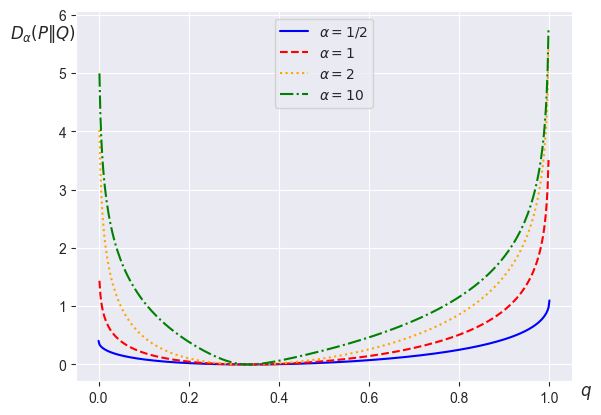

In [22]:
fig, ax = plt.subplots()

ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists_2[0])), color='blue', linestyle='-', label=r'$\alpha = 1/2$')
ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists_2[1])), color='red', linestyle='--', label=r'$\alpha = 1$')
ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists_2[2])), color='orange', linestyle=':', label=r'$\alpha = 2$')
ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists_2[3])), color='green', linestyle='-.', label=r'$\alpha = 10$')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.annotate(r'$q$', xy=(1.05, 0), xytext=(10, -20), 
            textcoords='offset points', ha='center', va='center', fontsize=12)

ax.annotate(r'$D_\alpha(P \| Q)$', xy=(0, 5.45), xytext=(-40, 10), 
            textcoords='offset points', ha='center', va='center', fontsize=12)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.legend()

fig.savefig('Renyi_Divergence_2.png')

plt.show()

In [8]:
# Definition of Decoupled Knowledge Distillation
class DKD(nn.Module):
    def __init__(self, alpha=1,beta=1):
        super(DKD, self).__init__()
        self.alpha = alpha
        self.beta = beta
    def forward(self, input_logits, target_logits,true_labels):
        target_mask = torch.zeros_like(target_logits).scatter_(1, true_labels.unsqueeze(1), 1).bool()
        
        p_t = torch.exp(torch.sum(target_logits*target_mask,dim=1,keepdim=True))/torch.sum(torch.exp(target_logits),dim=1,keepdim=True)
        q_t = torch.exp(torch.sum(input_logits*target_mask,dim=1,keepdim=True))/torch.sum(torch.exp(input_logits),dim=1,keepdim=True)
        
        b = torch.cat([p_t,1-p_t],dim=1)+0.000001
        d = torch.cat([q_t,1-q_t],dim=1)+0.000001
        
        tckd = torch.sum(b * torch.log(b / d), dim=1)
        
        p_hat = F.softmax(target_logits-1000.0*target_mask,dim=1)+0.000001*target_mask
        q_hat = F.softmax(input_logits-1000.0*target_mask,dim=1)+0.000001*target_mask
        
        nckd = torch.sum(p_hat * torch.log(p_hat/q_hat),dim=1)
        
        #return torch.mean(tckd + (1-p_t) * nckd) ## If we plug this in we get KD
        
        return torch.mean(self.alpha * tckd + self.beta * nckd)

In [9]:
# Test
true_labels = torch.tensor([1,1])
x = torch.tensor([[2/3,1/3,1/3],[2/3,1/3,1/3]],requires_grad=True)
y = torch.tensor([[1/3,2/3,1/3],[1/3,2/3,1/3]])
output = DKD(alpha=1,beta=1)(x,y,true_labels)
print(output)
output.backward()
print(x.grad)

tensor(0.0445, grad_fn=<MeanBackward0>)
tensor([[ 0.0752, -0.0583, -0.0170],
        [ 0.0752, -0.0583, -0.0170]])


In [10]:
# Test
true_labels = torch.tensor([1, 2])
x = torch.tensor([[0.9513, -0.0333, -0.2298], [-1.3912, -0.6202, -0.1879]], requires_grad=True)
y = torch.tensor([[-6.6371, 19.0506, -4.3150], [-5.8639, -4.1558, -1.3362]])
output = DKD(alpha=0.5, beta=0.5)(x, y, true_labels)
print(output)
output.backward()
print(x.grad)

tensor(0.7610, grad_fn=<MeanBackward0>)
tensor([[ 0.3177, -0.1944, -0.1233],
        [ 0.0740,  0.0313, -0.1053]])


In [11]:
# Definition of Generalized Decoupled Knowledge Distillation
class GDKD(nn.Module):
    def __init__(self, alpha=0.5,delta=1,gamma=1):
        super(GDKD, self).__init__()
        self.alpha = alpha
        self.delta = delta
        self.gamma = gamma
    def forward(self, input_logits, target_logits,true_labels):
        if self.alpha == 1:
            return DKD(alpha=self.delta,beta=self.gamma)(input_logits,target_logits,true_labels)
        
        target_mask = torch.zeros_like(target_logits).scatter_(1, true_labels.unsqueeze(1), 1).bool()
        
        p_t = torch.exp(torch.sum(target_logits*target_mask,dim=1,keepdim=True))/torch.sum(torch.exp(target_logits),dim=1,keepdim=True)
        q_t = torch.exp(torch.sum(input_logits*target_mask,dim=1,keepdim=True))/torch.sum(torch.exp(input_logits),dim=1,keepdim=True)
        
        b = torch.cat([p_t,1-p_t],dim=1)+0.000001
        d = torch.cat([q_t,1-q_t],dim=1)+0.000001
        
        tckd = 1/(self.alpha-1) * torch.log(torch.sum(torch.pow(b,self.alpha)*torch.pow(d,1-self.alpha),dim=1))
        
        p_hat = F.softmax(target_logits-1000.0*target_mask,dim=1)+0.000001*target_mask
        q_hat = F.softmax(input_logits-1000.0*target_mask,dim=1)+0.000001*target_mask
        
        nckd = 1/(self.alpha-1) * torch.log(torch.sum(torch.pow(p_hat,self.alpha)*torch.pow(q_hat,1-self.alpha),dim=1))
        
        return torch.mean(self.delta * tckd + self.gamma * nckd)

In [12]:
# Test
true_labels = torch.tensor([1, 1])
x = torch.tensor([[2 / 3, 1 / 3, 1 / 3], [2 / 3, 1 / 3, 1 / 3]], requires_grad=True)
y = torch.tensor([[1 / 3, 2 / 3, 1 / 3], [1 / 3, 2 / 3, 1 / 3]])
output = GDKD(alpha=0.5, gamma=1,delta=1)(x, y, true_labels)
print(output)
output.backward()
print(x.grad)

tensor(0.0219, grad_fn=<MeanBackward0>)
tensor([[ 0.0368, -0.0280, -0.0088],
        [ 0.0368, -0.0280, -0.0088]])


In [13]:
# Test
true_labels = torch.tensor([1, 2])
x = torch.tensor([[0.9513, -0.0333, -0.2298], [-1.3912, -0.6202, -0.1879]], requires_grad=True)
y = torch.tensor([[-6.6371, 19.0506, -4.3150], [-5.8639, -4.1558, -1.3362]])
output = GDKD(alpha=1, gamma=0.5,delta=0.5)(x, y, true_labels)
print(output)
output.backward()
print(x.grad)

tensor(0.7610, grad_fn=<MeanBackward0>)
tensor([[ 0.3177, -0.1944, -0.1233],
        [ 0.0740,  0.0313, -0.1053]])


In [14]:
class NKD(nn.Module):
    def __init__(self, alpha=1):
        super(NKD, self).__init__()
        self.alpha = alpha

    def forward(self, input_logits, target_logits, true_labels):
        target_mask = torch.zeros_like(target_logits).scatter_(1, true_labels.unsqueeze(1), 1).bool()

        p_t = torch.exp(torch.sum(target_logits * target_mask, dim=1, keepdim=True)) / torch.sum(
            torch.exp(target_logits), dim=1, keepdim=True)
        q_t = torch.exp(torch.sum(input_logits * target_mask, dim=1, keepdim=True)) / torch.sum(torch.exp(input_logits),
                                                                                                dim=1, keepdim=True)
        p_hat = F.softmax(target_logits - 1000.0 * target_mask, dim=1) + 0.000001 * target_mask
        q_hat = F.softmax(input_logits - 1000.0 * target_mask, dim=1) + 0.000001 * target_mask
        
        return (-(1+p_t.squeeze()) * torch.log(q_t.squeeze()) - self.alpha * torch.sum(p_hat * torch.log(q_hat), dim=1)).mean()

In [15]:
# Test
true_labels = torch.tensor([1, 1])
x = torch.tensor([[2 / 3, 1 / 3, 1 / 3], [2 / 3, 1 / 3, 1 / 3]], requires_grad=True)
y = torch.tensor([[1 / 3, 2 / 3, 1 / 3], [1 / 3, 2 / 3, 1 / 3]])
output = NKD(alpha=1.5)(x, y, true_labels)
print(output)
output.backward()
print(x.grad)

tensor(2.7854, grad_fn=<MeanBackward0>)
tensor([[ 0.3519, -0.4977,  0.1458],
        [ 0.3519, -0.4977,  0.1458]])


In [16]:
# Test
true_labels = torch.tensor([1, 2])
x = torch.tensor([[0.9513, -0.0333, -0.2298], [-1.3912, -0.6202, -0.1879]], requires_grad=True)
y = torch.tensor([[-6.6371, 19.0506, -4.3150], [-5.8639, -4.1558, -1.3362]])
output = NKD(alpha=1.5)(x, y, true_labels)
print(output)
output.backward()
print(x.grad)

tensor(3.5305, grad_fn=<MeanBackward0>)
tensor([[ 1.1019, -0.7777, -0.3242],
        [ 0.2711,  0.1999, -0.4710]])


In [17]:
class RenyiDivergenceLoss(nn.Module):
    """
    Knowledge distillation loss with Renyi Divergence
    """
    def __init__(self, alpha=0.5,beta=0.5):
        super(RenyiDivergenceLoss, self).__init__()
        assert alpha > 0
        assert beta >= 0 and beta <= 1
        self.alpha = alpha
        self.beta = beta

    def forward(self, x: torch.Tensor, y: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        CE = nn.CrossEntropyLoss()(x,target)
        q = torch.softmax(x, dim=1)
        p = torch.softmax(y, dim=1)

        if self.alpha == 1:  # KL Divergence
            return (1-self.beta) * CE + self.beta * torch.sum(p * torch.log(p / q), dim=1).mean()

        return (1-self.beta) * CE + self.beta *  1 / (self.alpha - 1) * torch.log(
            torch.sum(torch.pow(p, self.alpha) * torch.pow(q, 1 - self.alpha), dim=1)).mean()

In [25]:
# Test
true_labels = torch.tensor([1, 1])
x = torch.tensor([[2 / 3, 1 / 3, 1 / 3], [2 / 3, 1 / 3, 1 / 3]], requires_grad=True)
y = torch.tensor([[1 / 3, 2 / 3, 1 / 3], [1 / 3, 2 / 3, 1 / 3]])
output = RenyiDivergenceLoss(alpha=1)(x,y,true_labels)
print(output)
output.backward()
print(x.grad)

tensor(0.6307, grad_fn=<AddBackward0>)
tensor([[ 0.1319, -0.2055,  0.0736],
        [ 0.1319, -0.2055,  0.0736]])


In [19]:
class DKDLoss(nn.Module):
    def __init__(self, beta = 0.5, zeta=0.5, temperature=1):
        super(DKDLoss, self).__init__()
        assert beta >= 0 and beta <= 1
        assert zeta >= 0 and beta <= 1
        assert temperature > 0
        self.beta = beta
        self.zeta = zeta
        self.temperature = temperature

    def forward(self, x: torch.Tensor, y: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        CE = nn.CrossEntropyLoss()(x, target)
        x = x/self.temperature
        y = y/self.temperature
        target_mask = torch.zeros_like(y).scatter_(1, target.unsqueeze(1), 1).bool()

        p_t = torch.exp(torch.sum(y * target_mask, dim=1, keepdim=True)) / torch.sum(
            torch.exp(y), dim=1, keepdim=True)
        q_t = torch.exp(torch.sum(x * target_mask, dim=1, keepdim=True)) / torch.sum(torch.exp(x),
                                                                                                dim=1, keepdim=True)

        b = torch.cat([p_t, 1 - p_t], dim=1) + 0.000001
        d = torch.cat([q_t, 1 - q_t], dim=1) + 0.000001

        tckd = torch.sum(b * torch.log(b / d), dim=1)

        p_hat = F.softmax(y - 1000.0 * target_mask, dim=1) + 0.000001 * target_mask
        q_hat = F.softmax(x - 1000.0 * target_mask, dim=1) + 0.000001 * target_mask

        nckd = torch.sum(p_hat * torch.log(p_hat / q_hat), dim=1)

        return (1-self.beta) * CE + self.beta * torch.mean((1-self.zeta) * tckd + self.zeta * nckd) * (self.temperature ** 2)

In [20]:
# Test
true_labels = torch.tensor([1, 1])
x = torch.tensor([[2 / 3, 1 / 3, 1 / 3], [2 / 3, 1 / 3, 1 / 3]], requires_grad=True)
y = torch.tensor([[1 / 3, 2 / 3, 1 / 3], [1 / 3, 2 / 3, 1 / 3]])
output = DKDLoss()(x,y,true_labels)
print(output)
output.backward()
print(x.grad)

tensor(0.6224, grad_fn=<AddBackward0>)
tensor([[ 0.1216, -0.1909,  0.0694],
        [ 0.1216, -0.1909,  0.0694]])


In [21]:
8/9

0.8888888888888888

In [22]:
9/10

0.9

In [5]:
np.random.normal(5, 1, 5)

array([6.46564877, 4.7742237 , 5.0675282 , 3.57525181, 4.45561728])

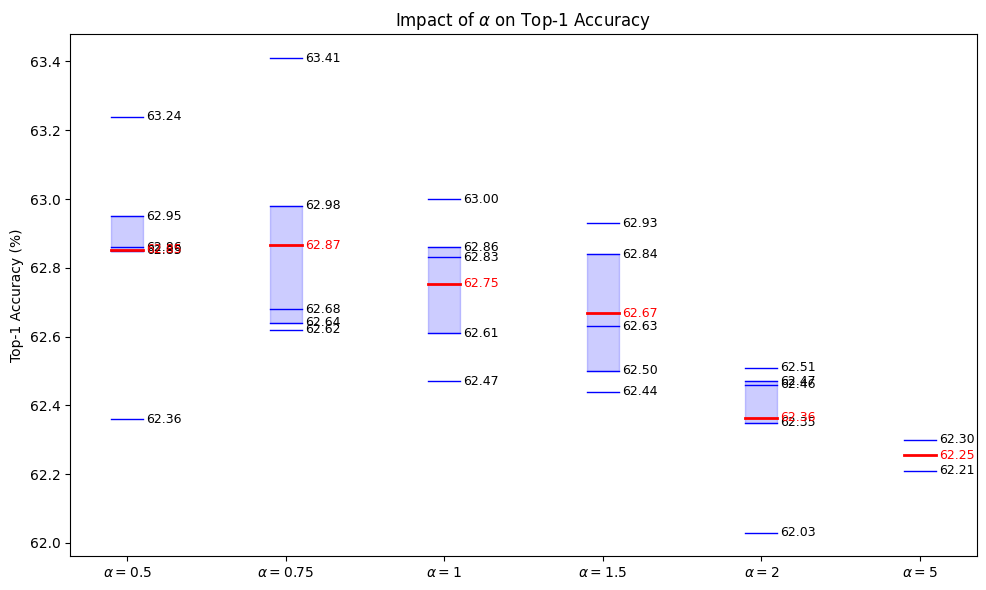

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Příkladová data
np.random.seed(42)
data = {
    'Skupina 1': np.array([62.95,62.85,62.36,63.24,62.86]),
    'Skupina 2': np.array([62.62,63.41,62.98,62.68,62.64]),
    'Skupina 3': np.array([62.47,62.86,62.83,63,62.61]),
    'Skupina 4': np.array([62.5,62.84,62.93,62.44,62.63]),
    'Skupina 5': np.array([62.03,62.51,62.46,62.47,62.35]),
    'Skupina 6': np.array([62.21,62.3]),
}

# Nastavení parametrů pro popisky
alpha_values = [0.5, 0.75, 1, 1.5, 2, 5]  # Hodnoty alpha

# Nastavení grafu
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.2  # Šířka "boxplotu"

for i, (label, values) in enumerate(data.items()):
    x = [i + 1] * len(values)
    sorted_values = np.sort(values)
    
    # Jednotlivé čáry pro pozorování
    for xi, yi in zip(x, values):
        ax.plot([xi - width / 2, xi + width / 2], [yi, yi], color='blue', lw=1)
        ax.text(xi + 0.12, yi, f"{yi:.2f}", va='center', fontsize=9)
    
    # Spojení 2. a 4. hodnoty průhledným obdélníkem
    if len(values) > 3:
        rect_y_min, rect_y_max = sorted_values[1], sorted_values[3]
        ax.add_patch(plt.Rectangle((i + 1 - width / 2, rect_y_min), width, rect_y_max - rect_y_min, 
                                    color='blue', alpha=0.2))
    
    # Průměrná hodnota
    mean_value = np.mean(values)
    ax.plot([i + 1 - width / 2, i + 1 + width / 2], [mean_value, mean_value], color='red', lw=2)
    ax.text(i + 1 + 0.12, mean_value, f"{mean_value:.2f}", va='center', fontsize=9, color='red')

# Vzhled grafu
alpha_labels = [f"$\\alpha = {k}$" for k in alpha_values]
ax.set_xticks(range(1, len(data) + 1))
ax.set_xticklabels(alpha_labels)
ax.set_ylabel('Top-1 Accuracy (%)')
ax.set_title(f'Impact of $\\alpha$ on Top-1 Accuracy')

plt.tight_layout()
plt.savefig('eval_top1.png')
plt.show()

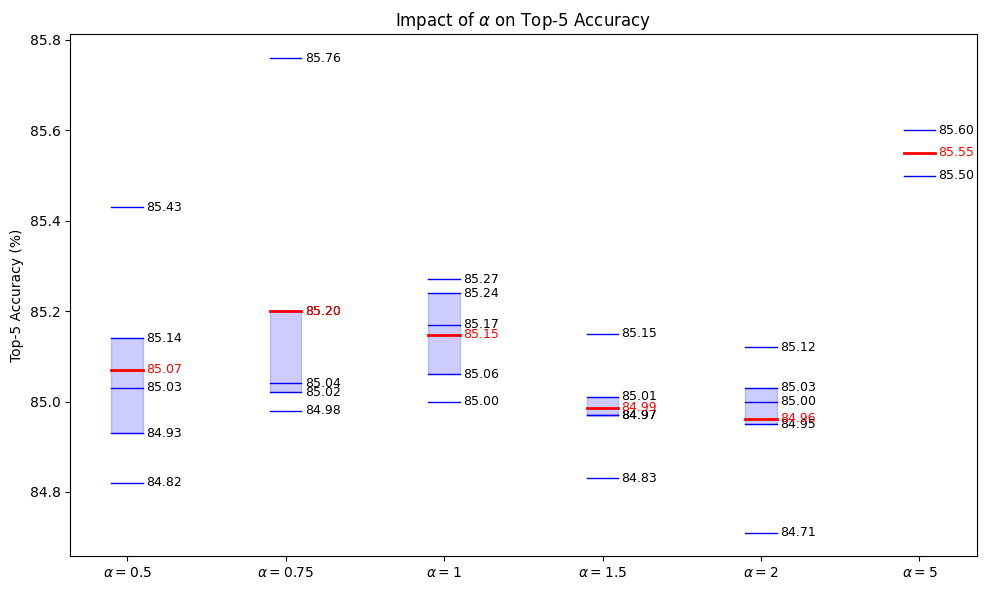

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Příkladová data
np.random.seed(42)
data = {
    'Skupina 1': np.array([85.14,84.93,85.43,84.82,85.03]),
    'Skupina 2': np.array([85.76,85.2,84.98,85.04,85.02]),
    'Skupina 3': np.array([85.27,85.06,85.24,85,85.17]),
    'Skupina 4': np.array([84.83,85.15,85.01,84.97,84.97]),
    'Skupina 5': np.array([84.95,85,85.03,85.12,84.71]),
    'Skupina 6': np.array([85.5,85.6]),
}

# Nastavení parametrů pro popisky
alpha_values = [0.5, 0.75, 1, 1.5, 2, 5]  # Hodnoty alpha

# Nastavení grafu
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.2  # Šířka "boxplotu"

for i, (label, values) in enumerate(data.items()):
    x = [i + 1] * len(values)
    sorted_values = np.sort(values)
    
    # Jednotlivé čáry pro pozorování
    for xi, yi in zip(x, values):
        ax.plot([xi - width / 2, xi + width / 2], [yi, yi], color='blue', lw=1)
        ax.text(xi + 0.12, yi, f"{yi:.2f}", va='center', fontsize=9)
    
    # Spojení 2. a 4. hodnoty průhledným obdélníkem
    if len(values) > 3:
        rect_y_min, rect_y_max = sorted_values[1], sorted_values[3]
        ax.add_patch(plt.Rectangle((i + 1 - width / 2, rect_y_min), width, rect_y_max - rect_y_min, 
                                    color='blue', alpha=0.2))
    
    # Průměrná hodnota
    mean_value = np.mean(values)
    ax.plot([i + 1 - width / 2, i + 1 + width / 2], [mean_value, mean_value], color='red', lw=2)
    ax.text(i + 1 + 0.12, mean_value, f"{mean_value:.2f}", va='center', fontsize=9, color='red')

# Vzhled grafu
alpha_labels = [f"$\\alpha = {k}$" for k in alpha_values]
ax.set_xticks(range(1, len(data) + 1))
ax.set_xticklabels(alpha_labels)
ax.set_ylabel('Top-5 Accuracy (%)')
ax.set_title(f'Impact of $\\alpha$ on Top-5 Accuracy')

plt.tight_layout()
plt.savefig('eval_top5.png')
plt.show()

In [1]:
import seaborn as sns

# Data
data = {"Horse": 5.4, "Zebra": 0.2, "Car": -1.3}
classes, logits = zip(*data.items())
logits = np.array(logits)

# Transformations
probabilities = np.exp(logits)/np.sum(np.exp(logits))
probabilities_T4 = np.exp(logits/4)/np.sum(np.exp(logits/4))

# Set academic-style aesthetics
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Wider figure for clarity

# Logits plot
sns.barplot(x=classes, y=logits, palette="gray", ax=axes[0],hue=classes)
axes[0].set_title("Logit Values")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Logit Value")

# Probabilities without temperature scaling
sns.barplot(x=classes, y=probabilities, palette="gray", ax=axes[1],hue=classes)
axes[1].set_ylim(0, 1)
axes[1].set_title(r'Predicted Probabilities with $T=1$')
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Probability")

# Probabilities with temperature scaling
sns.barplot(x=classes, y=probabilities_T4, palette="gray", ax=axes[2],hue=classes)
axes[2].set_ylim(0, 1)
axes[2].set_title(r'Predicted Probabilities with $T=4$')
axes[2].set_xlabel("Class")
axes[2].set_ylabel("Probability")

# Remove spines for a cleaner look
for ax in axes:
    sns.despine(ax=ax)

# Adjust layout
plt.tight_layout()
fig.savefig("temperature_example_plot.pdf", format="pdf", bbox_inches="tight")  # High-quality for papers
plt.show()

NameError: name 'np' is not defined